In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1. 데이터 가공

In [2]:
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv('https://raw.githubusercontent.com/pykwon/python/refs/heads/master/testdata_utf8/pima-indians-diabetes.data.csv', header=None, names=column_names)
print(data.head())
print(data.info())
x_data = data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
y_data = data[['Outcome']]

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768

# 2. Train / Test 분류

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.3, random_state=12, shuffle=True, stratify=y_data)
print(x_train.shape,x_test.shape, y_train.shape, y_test.shape) # (537, 8) (231, 8) (537, 1) (231, 1)
print(x_train[:5])
print(y_train[:5])

(537, 8) (231, 8) (537, 1) (231, 1)
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
483            0       84             82             31      125  38.2   
215           12      151             70             40      271  41.8   
346            1      139             46             19       83  28.7   
692            2      121             70             32       95  39.1   
577            2      118             80              0        0  42.9   

     DiabetesPedigreeFunction  Age  
483                     0.233   23  
215                     0.742   38  
346                     0.654   22  
692                     0.886   23  
577                     0.693   21  
     Outcome
483        0
215        1
346        0
692        0
577        1


# 3. Sequential API 방식 (option : Dropout, BatchNormalization)

In [4]:
# 모델 생성 Sequential API 방식
model = Sequential()
model.add(Input(shape=(8,)))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2)) # 과적합 방지용
model.add(BatchNormalization()) # 배치 정규화, 역전파시 기울기 소실 또는 폭주 방지, CNN에서 효과적임
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(rate=0.1)) # 과적합 방지용
model.add(BatchNormalization())
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam' ,loss='binary_crossentropy', metrics=['accuracy'])
# fit() 전에 model score 확인
loss, acc = model.evaluate(x_train, y_train , verbose=0)
print('훈련 전 모델 정확도{:5.2f}%'.format(100 * acc)) # 훈련 전 모델 정확도 34.82%

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,153 (4.50 KB)

 Trainable params: 1,057 (4.13 KB)

 Non-trainable params: 96 (384.00 B)

훈련 전 모델 정확도36.69%


# 4. 학습 (option : early_stop)

In [5]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(x_train, y_train, validation_split= 0.2, epochs=1000, batch_size=64,callbacks=[early_stop],verbose=2)

loss, acc = model.evaluate(x_test, y_test, batch_size=64, verbose=0)
print('훈련 후 모델 정확도{:5.2f}%'.format(100 * acc)) # 훈련 후 모델 정확도 69.70%

Epoch 1/1000
7/7 - 1s - 163ms/step - accuracy: 0.4942 - loss: 0.8097 - val_accuracy: 0.4722 - val_loss: 0.9351
Epoch 2/1000
7/7 - 0s - 11ms/step - accuracy: 0.5105 - loss: 0.7725 - val_accuracy: 0.4630 - val_loss: 0.8199
Epoch 3/1000
7/7 - 0s - 14ms/step - accuracy: 0.5338 - loss: 0.7239 - val_accuracy: 0.4444 - val_loss: 0.7693
Epoch 4/1000
7/7 - 0s - 10ms/step - accuracy: 0.5897 - loss: 0.7027 - val_accuracy: 0.4259 - val_loss: 0.7420
Epoch 5/1000
7/7 - 0s - 10ms/step - accuracy: 0.5641 - loss: 0.6971 - val_accuracy: 0.4259 - val_loss: 0.7244
Epoch 6/1000
7/7 - 0s - 10ms/step - accuracy: 0.6340 - loss: 0.6670 - val_accuracy: 0.4444 - val_loss: 0.7110
Epoch 7/1000
7/7 - 0s - 10ms/step - accuracy: 0.6294 - loss: 0.6445 - val_accuracy: 0.4907 - val_loss: 0.6966
Epoch 8/1000
7/7 - 0s - 10ms/step - accuracy: 0.6247 - loss: 0.6563 - val_accuracy: 0.5370 - val_loss: 0.6817
Epoch 9/1000
7/7 - 0s - 9ms/step - accuracy: 0.6131 - loss: 0.6632 - val_accuracy: 0.5833 - val_loss: 0.6706
Epoch 10/1

# 5. 시각화

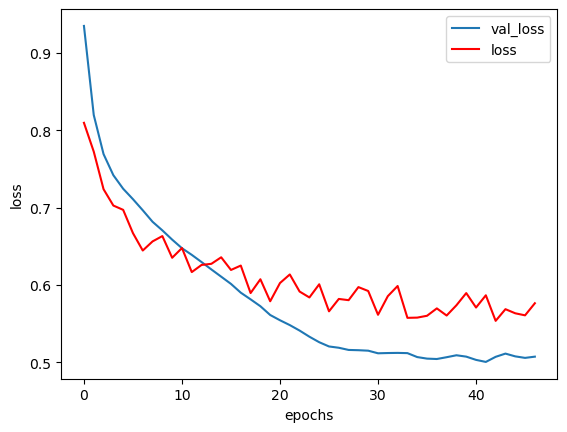

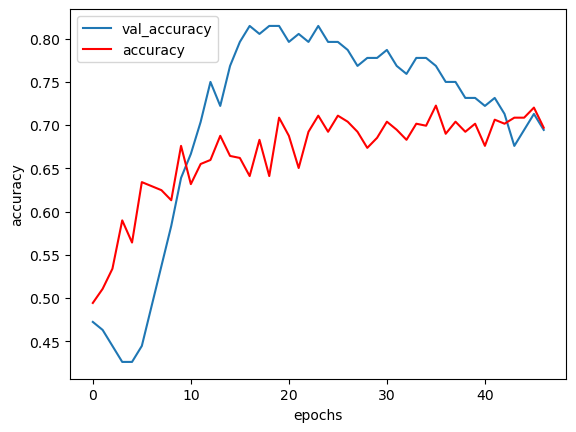

In [6]:
# 시각화
epoch_len = np.arange(len(history.epoch))

plt.plot(epoch_len, history.history['val_loss'], label = 'val_loss')
plt.plot(epoch_len, history.history['loss'], label = 'loss', c='red')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc= 'best')
plt.show()

plt.plot(epoch_len, history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(epoch_len, history.history['accuracy'], label = 'accuracy', c='red')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc= 'best')

# 3.1 Functional api 방식 (option : Dropout, BatchNormalization)

In [7]:
# 모델 정의 방법 2: Functional api
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=(8,))
x = Dense(units=32, activation='relu')(inputs)
x = Dropout(rate=0.2)(x)
x = BatchNormalization()(x)
x = Dense(units=16, activation='relu')(x)
x = Dropout(rate=0.1)(x)
x = BatchNormalization()(x)
x = Dense(units=8, activation='relu')(x)
outputs = Dense(units=1, activation='sigmoid')(x)
model2 = Model(inputs=inputs, outputs=outputs)
model2.summary()
model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01),metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10)
loss, acc = model2.evaluate(x_train, y_train , verbose=0)
print('훈련 전 모델 정확도{:5.2f}%'.format(100 * acc)) # 훈련 전 모델 정확도33.71%
history2 = model2.fit(x_train, y_train, validation_split= 0.2, epochs=1000, batch_size=64,callbacks=[early_stop],verbose=2)

loss, acc = model2.evaluate(x_test, y_test, batch_size=64, verbose=0)
print('훈련 후 모델 정확도{:5.2f}%'.format(100 * acc)) # 훈련 후 모델 정확도68.40%

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,153 (4.50 KB)

 Trainable params: 1,057 (4.13 KB)

 Non-trainable params: 96 (384.00 B)

훈련 전 모델 정확도59.96%
Epoch 1/1000
7/7 - 1s - 188ms/step - accuracy: 0.3706 - loss: 0.8679 - val_accuracy: 0.3611 - val_loss: 0.9803
Epoch 2/1000
7/7 - 0s - 10ms/step - accuracy: 0.4755 - loss: 0.7227 - val_accuracy: 0.3889 - val_loss: 0.7788
Epoch 3/1000
7/7 - 0s - 10ms/step - accuracy: 0.6643 - loss: 0.6614 - val_accuracy: 0.3796 - val_loss: 0.8501
Epoch 4/1000
7/7 - 0s - 9ms/step - accuracy: 0.6410 - loss: 0.6429 - val_accuracy: 0.4352 - val_loss: 0.8279
Epoch 5/1000
7/7 - 0s - 9ms/step - accuracy: 0.6853 - loss: 0.6098 - val_accuracy: 0.5741 - val_loss: 0.7370
Epoch 6/1000
7/7 - 0s - 9ms/step - accuracy: 0.6993 - loss: 0.5820 - val_accuracy: 0.5370 - val_loss: 0.8051
Epoch 7/1000
7/7 - 0s - 10ms/step - accuracy: 0.7063 - loss: 0.5873 - val_accuracy: 0.5926 - val_loss: 0.7609
Epoch 8/1000
7/7 - 0s - 10ms/step - accuracy: 0.7133 - loss: 0.5715 - val_accuracy: 0.5926 - val_loss: 0.7187
Epoch 9/1000
7/7 - 0s - 12ms/step - accuracy: 0.7086 - loss: 0.5852 - val_accuracy: 0.6204 - val_loss: 0

# 5.1 시각화

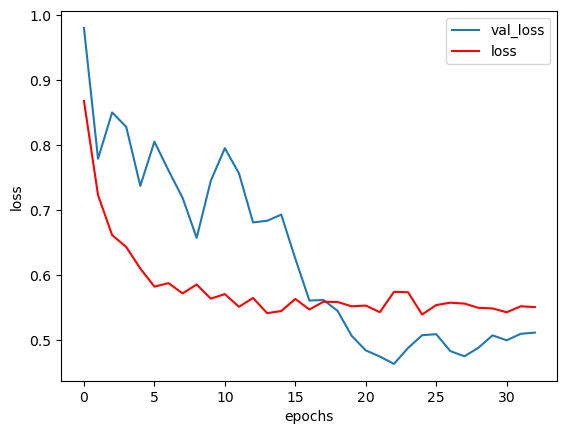

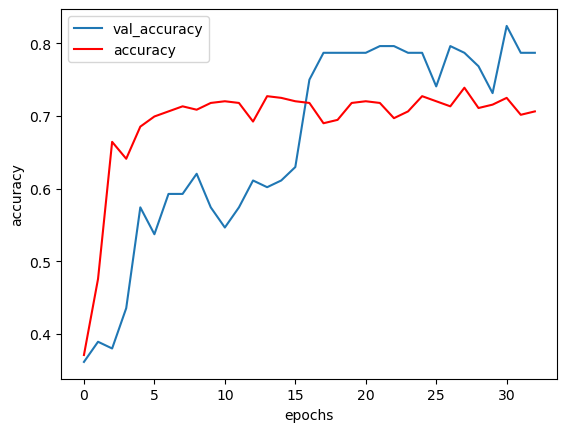

In [8]:
# 시각화
epoch_len = np.arange(len(history2.epoch))

plt.plot(epoch_len, history2.history['val_loss'], label = 'val_loss')
plt.plot(epoch_len, history2.history['loss'], label = 'loss', c='red')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc= 'best')
plt.show()

plt.plot(epoch_len, history2.history['val_accuracy'], label = 'val_accuracy')
plt.plot(epoch_len, history2.history['accuracy'], label = 'accuracy', c='red')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc = 'best')